<a href="https://colab.research.google.com/github/krishnamanc/PytorchPractice/blob/main/CatDog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!kaggle datasets download -d tongpython/cat-and-dog

Dataset URL: https://www.kaggle.com/datasets/tongpython/cat-and-dog
License(s): CC0-1.0
cat-and-dog.zip: Skipping, found more recently modified local copy (use --force to force download)


In [52]:
!unzip cat-and-dog.zip

Archive:  cat-and-dog.zip
replace test_set/test_set/cats/_DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace test_set/test_set/cats/cat.4001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace test_set/test_set/cats/cat.4002.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace test_set/test_set/cats/cat.4003.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace test_set/test_set/cats/cat.4004.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
!pip install torchinfo

In [3]:
# Codeblock 1
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms

from tqdm import tqdm
from torchinfo import summary
from torch.utils.data import DataLoader

In [4]:
# Codeblock 2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
# Codeblock 3
def load_images(path):

    images = []
    filenames = os.listdir(path)

    for filename in tqdm(filenames):
        if filename == '_DS_Store':
            continue
        image = cv2.imread(os.path.join(path, filename))
        image = cv2.resize(image, dsize=(100,100))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        images.append(image)

    return np.array(images)

In [6]:
# Codeblock 4
cats_train = load_images('/content/training_set/training_set/cats')
dogs_train = load_images('/content/training_set/training_set/dogs')

cats_test = load_images('/content/test_set/test_set/cats')
dogs_test = load_images('/content/test_set/test_set/dogs')

100%|██████████| 1013/1013 [00:02<00:00, 437.33it/s]


In [7]:
# Codeblock 5
print(cats_train.shape)
print(dogs_train.shape)
print(cats_test.shape)
print(dogs_test.shape)

(4000, 100, 100, 3)
(4005, 100, 100, 3)
(1011, 100, 100, 3)
(1012, 100, 100, 3)


In [8]:
# Codeblock 6
X_train = np.append(cats_train, dogs_train, axis=0)
X_test  = np.append(cats_test, dogs_test, axis=0)

print(X_train.shape)
print(X_test.shape)

(8005, 100, 100, 3)
(2023, 100, 100, 3)


In [9]:
# Codeblock 7
y_train = np.array([0] * len(cats_train) + [1] * len(dogs_train))
y_test = np.array([0] * len(cats_test) + [1] * len(dogs_test))

print(y_train.shape)
print(y_test.shape)

(8005,)
(2023,)


In [10]:
# Codeblock 8
def show_images(images, labels, start_index):
    fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(20,12))

    counter = start_index

    for i in range(4):
        for j in range(8):
            axes[i,j].set_title(labels[counter].item())
            axes[i,j].imshow(images[counter], cmap='gray')
            axes[i,j].get_xaxis().set_visible(False)
            axes[i,j].get_yaxis().set_visible(False)
            counter += 1
    plt.show()

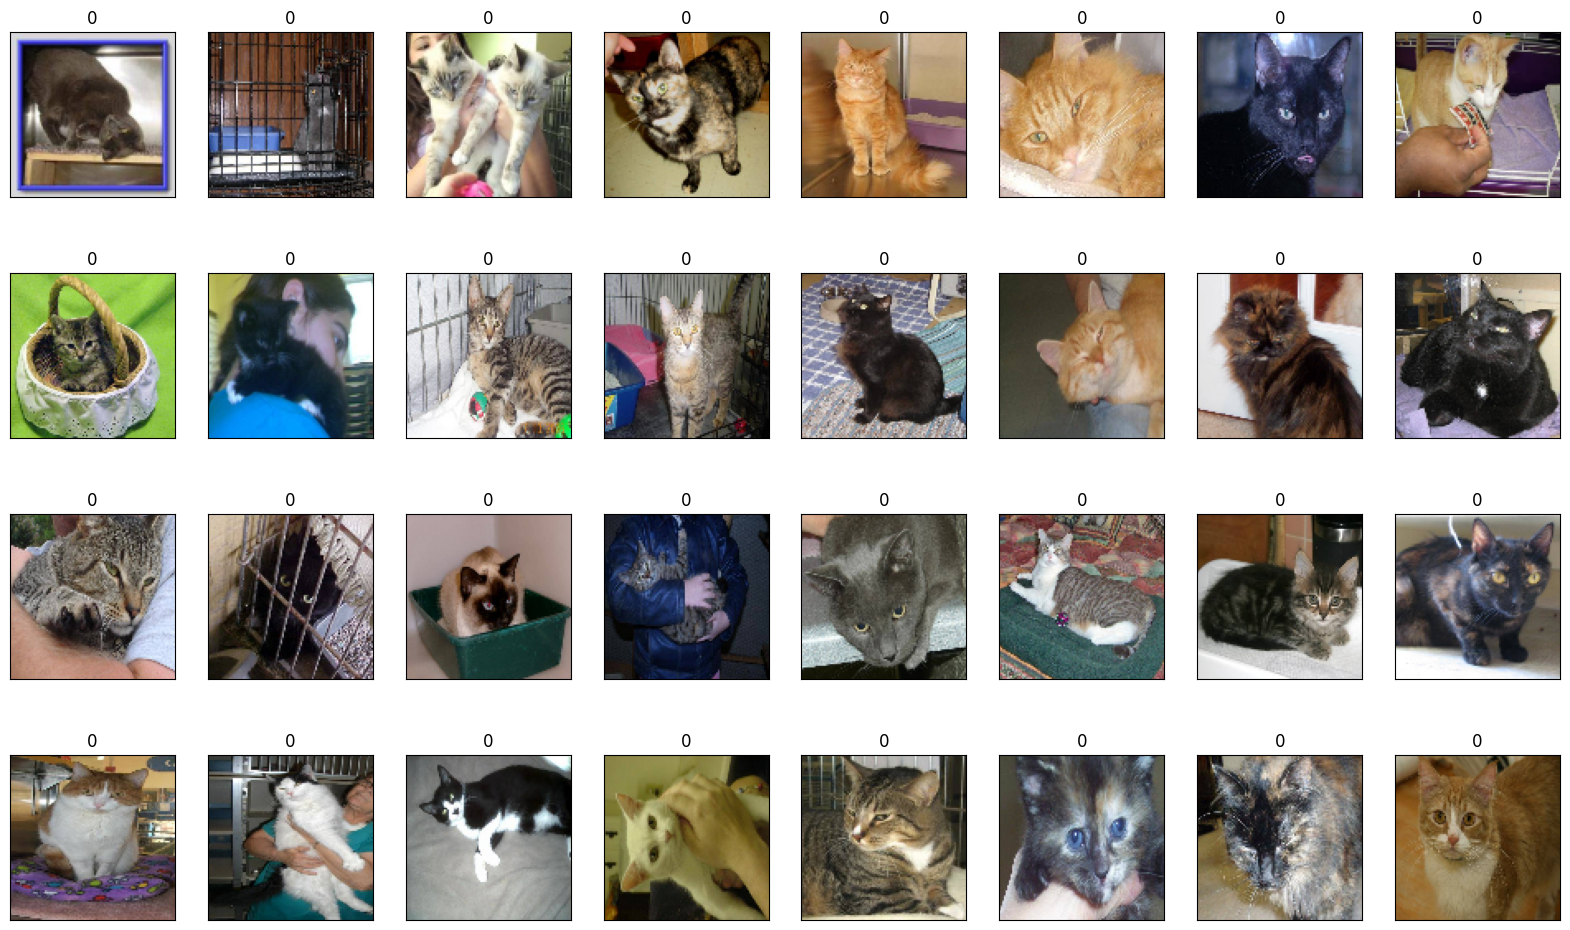

In [11]:
# Codeblock 9
show_images(X_train, y_train, 0)

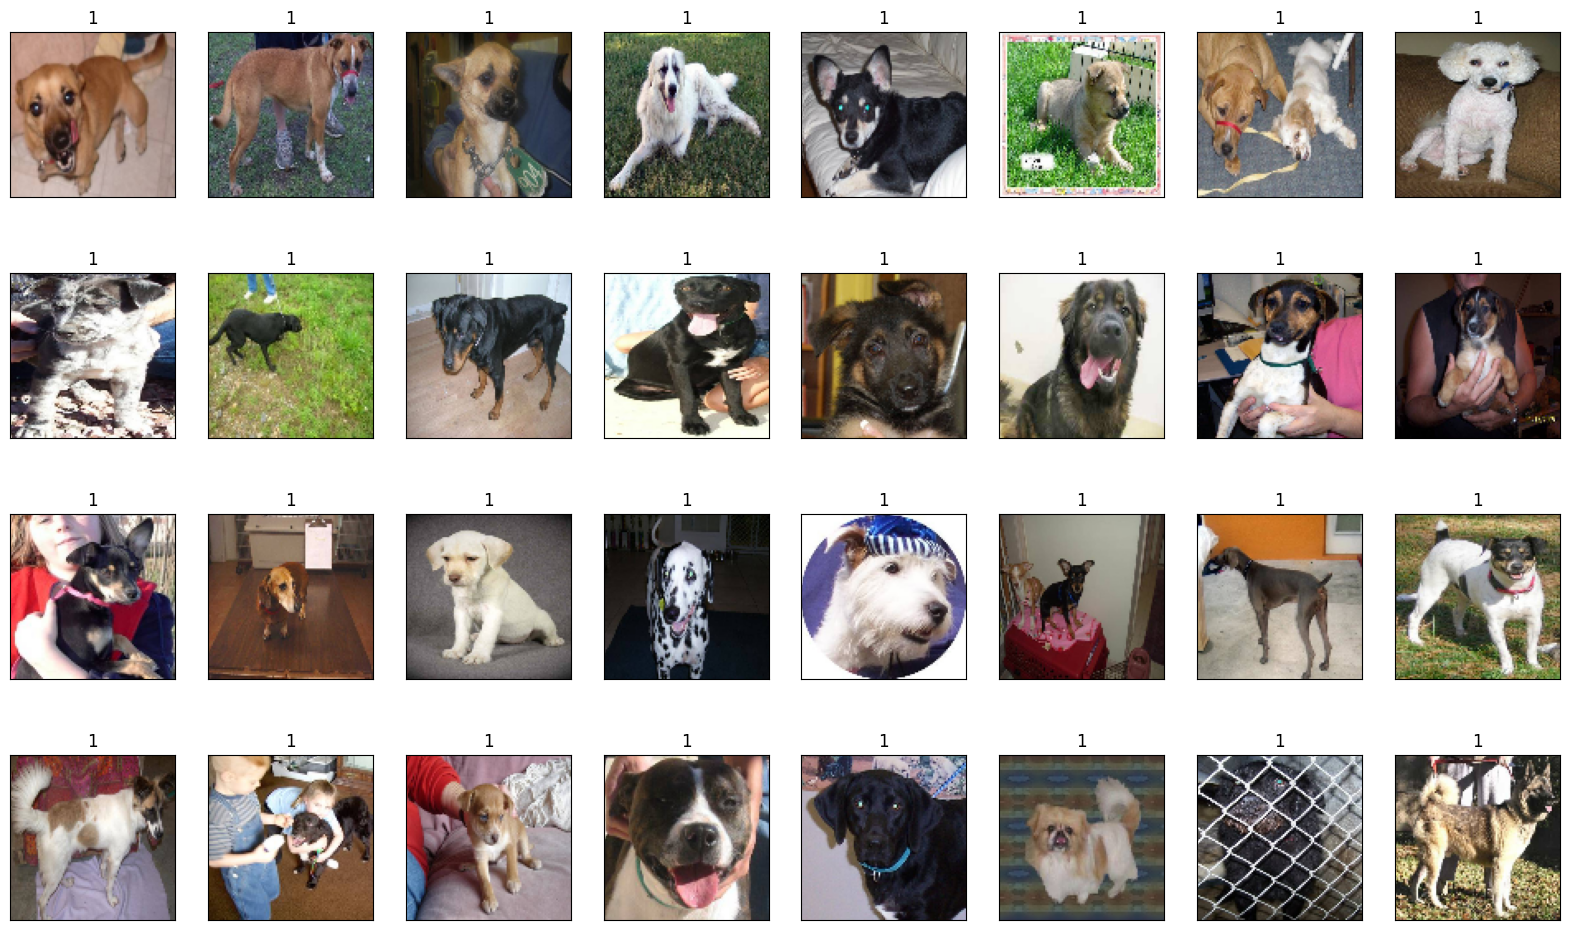

In [12]:
# Codeblock 10
show_images(X_train, y_train, 4000)

In [13]:
# Codeblock 11
print(y_train[:10])

[0 0 0 0 0 0 0 0 0 0]


In [14]:
# Codeblock 12
y_train = torch.from_numpy(y_train.reshape(len(y_train),1))
y_test = torch.from_numpy(y_test.reshape(len(y_test),1))

print(y_train[:10])

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]])


In [15]:
# Codeblock 13
transforms_train = transforms.Compose([transforms.ToTensor(), # convert to tensor
                                       transforms.RandomRotation(degrees=20),
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.RandomVerticalFlip(p=0.005),
                                       transforms.RandomGrayscale(p=0.2),
                                       transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]) # squeeze to -1 and 1
                                      ])

In [16]:
# Codeblock 14
transforms_test = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])])

In [17]:
# Codeblock 15
class Cat_Dog_Dataset():
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return (image, label)

In [18]:
# Codeblock 16
train_dataset = Cat_Dog_Dataset(images=X_train, labels=y_train, transform=transforms_train)
test_dataset  = Cat_Dog_Dataset(images=X_test, labels=y_test, transform=transforms_test)

In [19]:
# Codeblock 17
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=True, drop_last=True)

In [20]:
# Codeblock 18
iterator = iter(train_loader)
image_batch, label_batch = next(iterator)

print(image_batch.shape)

torch.Size([32, 3, 100, 100])


torch.Size([32, 100, 100, 3])


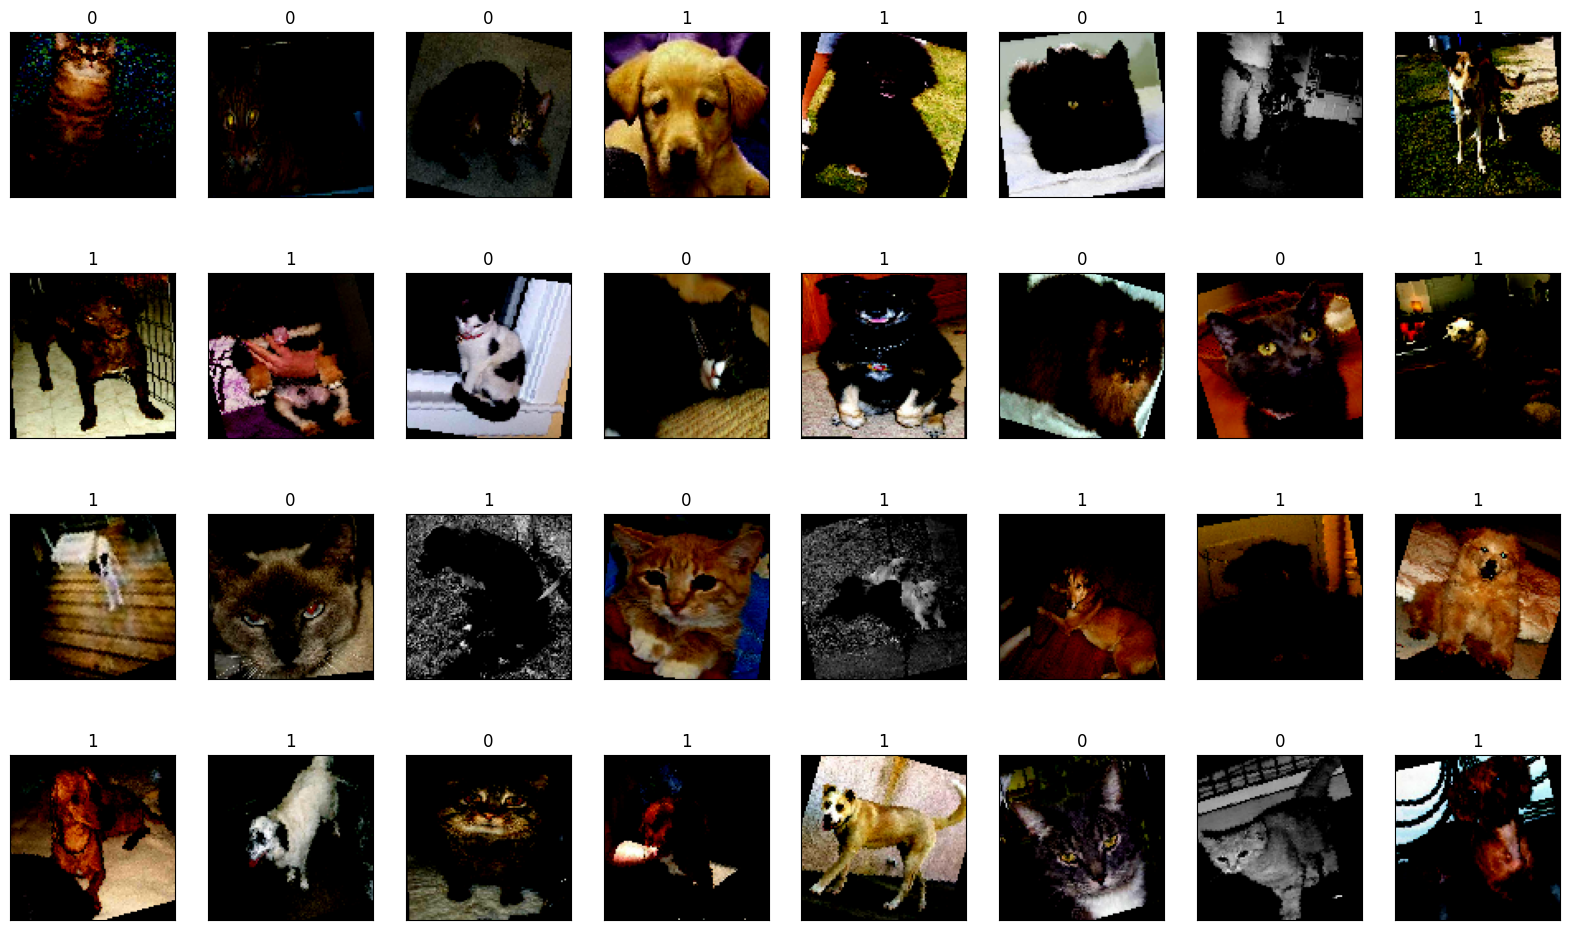

In [21]:
# Codeblock 19
image_batch_permuted = image_batch.permute(0, 2, 3, 1)

print(image_batch_permuted.shape)

show_images(image_batch_permuted, label_batch, 0)

In [22]:
X_train.shape

(8005, 100, 100, 3)

In [39]:
# Codeblock 20
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))

        self.conv1 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)

        self.dropout = nn.Dropout(p=0.5)


        self.fc0 = nn.Linear(in_features=128*3*3, out_features=64)
        self.fc1 = nn.Linear(in_features=64, out_features=32)
        self.fc2 = nn.Linear(in_features=32, out_features=1)

    def forward(self, x):
        x = F.relu(self.conv0(x))
        x = self.maxpool(x)

        x = F.relu(self.conv1(x))
        x = self.maxpool(x)

        x = F.relu(self.conv2(x))
        x = self.maxpool(x)

        x = F.relu(self.conv3(x))
        x = self.maxpool(x)

        x = F.relu(self.conv4(x))
        x = self.maxpool(x)

        x = x.view(x.size(0), -1)

        x = self.dropout(x)
        x = F.relu(self.fc0(x))
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))

        return x

In [40]:
# Codeblock 21
model = Model().to(device)

In [41]:
# Codeblock 22
summary(model, input_size=(4,3,100,100))

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [4, 1]                    --
├─Conv2d: 1-1                            [4, 8, 100, 100]          216
├─MaxPool2d: 1-2                         [4, 8, 50, 50]            --
├─Conv2d: 1-3                            [4, 16, 50, 50]           1,152
├─MaxPool2d: 1-4                         [4, 16, 25, 25]           --
├─Conv2d: 1-5                            [4, 32, 25, 25]           4,608
├─MaxPool2d: 1-6                         [4, 32, 12, 12]           --
├─Conv2d: 1-7                            [4, 64, 12, 12]           18,432
├─MaxPool2d: 1-8                         [4, 64, 6, 6]             --
├─Conv2d: 1-9                            [4, 128, 6, 6]            73,728
├─MaxPool2d: 1-10                        [4, 128, 3, 3]            --
├─Dropout: 1-11                          [4, 1152]                 --
├─Linear: 1-12                           [4, 64]                   73,

In [42]:
# Codeblock 23
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [43]:
# Codeblock 24
def predict_test_data(model, test_loader):

    num_correct = 0
    num_samples = 0

    model.eval()

    with torch.no_grad():
        for batch, (X_test, y_test) in enumerate(test_loader):
            X_test = X_test.float().to(device)
            y_test = y_test.float().to(device)

            # Calculate loss (forward propagation)
            test_preds = model(X_test)
            test_loss  = loss_function(test_preds, y_test)

            # Calculate accuracy
            rounded_test_preds = torch.round(test_preds)
            num_correct += torch.sum(rounded_test_preds == y_test)
            num_samples += len(y_test)

    model.train()

    test_acc = num_correct/num_samples

    return test_loss, test_acc

In [49]:
# Codeblock 25

train_losses = []    # Training and testing loss was calculated based on the last batch of each epoch.
test_losses  = []
train_accs = []
test_accs  = []
model.train()
for epoch in range(20):

    num_correct_train = 0
    num_samples_train = 0
    for batch, (X_train, y_train) in tqdm(enumerate(train_loader), total=len(train_loader)):
        X_train = X_train.float().to(device)
        y_train = y_train.float().to(device)

        # Forward propagation
        train_preds = model(X_train)
        train_loss = loss_function(train_preds, y_train)

        # Calculate train accuracy
        with torch.no_grad():
            rounded_train_preds = torch.round(train_preds)
            num_correct_train += torch.sum(rounded_train_preds == y_train)
            num_samples_train += len(y_train)

        # Backward propagation
        optimizer.zero_grad()
        train_loss.backward()

        # Gradient descent
        optimizer.step()

    train_acc = num_correct_train/num_samples_train
    test_loss, test_acc = predict_test_data(model, test_loader)

    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())
    train_accs.append(train_acc.item())
    test_accs.append(test_acc.item())

    print(f'Epoch: {epoch} \t|' \
            f' Train loss: {np.round(train_loss.item(),3)} \t|' \
            f' Test loss: {np.round(test_loss.item(),3)} \t|' \
            f' Train acc: {np.round(train_acc.item(),2)} \t|' \
            f' Test acc: {np.round(test_acc.item(),2)}')

100%|██████████| 250/250 [00:11<00:00, 21.96it/s]


Epoch: 0 	| Train loss: 0.104 	| Test loss: 0.348 	| Train acc: 0.93 	| Test acc: 0.91


100%|██████████| 250/250 [00:11<00:00, 22.19it/s]


Epoch: 1 	| Train loss: 0.174 	| Test loss: 0.165 	| Train acc: 0.94 	| Test acc: 0.9


100%|██████████| 250/250 [00:11<00:00, 22.17it/s]


Epoch: 2 	| Train loss: 0.246 	| Test loss: 0.11 	| Train acc: 0.93 	| Test acc: 0.89


100%|██████████| 250/250 [00:11<00:00, 22.02it/s]


Epoch: 3 	| Train loss: 0.228 	| Test loss: 0.306 	| Train acc: 0.94 	| Test acc: 0.91


100%|██████████| 250/250 [00:11<00:00, 22.15it/s]


Epoch: 4 	| Train loss: 0.178 	| Test loss: 0.152 	| Train acc: 0.93 	| Test acc: 0.91


100%|██████████| 250/250 [00:11<00:00, 22.67it/s]


Epoch: 5 	| Train loss: 0.137 	| Test loss: 0.121 	| Train acc: 0.93 	| Test acc: 0.9


100%|██████████| 250/250 [00:10<00:00, 22.82it/s]


Epoch: 6 	| Train loss: 0.189 	| Test loss: 0.353 	| Train acc: 0.94 	| Test acc: 0.91


100%|██████████| 250/250 [00:10<00:00, 23.00it/s]


Epoch: 7 	| Train loss: 0.123 	| Test loss: 0.236 	| Train acc: 0.94 	| Test acc: 0.9


100%|██████████| 250/250 [00:10<00:00, 22.94it/s]


Epoch: 8 	| Train loss: 0.186 	| Test loss: 0.131 	| Train acc: 0.94 	| Test acc: 0.9


100%|██████████| 250/250 [00:11<00:00, 22.52it/s]


Epoch: 9 	| Train loss: 0.228 	| Test loss: 0.249 	| Train acc: 0.94 	| Test acc: 0.91


100%|██████████| 250/250 [00:11<00:00, 22.18it/s]


Epoch: 10 	| Train loss: 0.465 	| Test loss: 3.388 	| Train acc: 0.94 	| Test acc: 0.9


100%|██████████| 250/250 [00:11<00:00, 22.10it/s]


Epoch: 11 	| Train loss: 0.084 	| Test loss: 0.165 	| Train acc: 0.94 	| Test acc: 0.9


100%|██████████| 250/250 [00:11<00:00, 22.09it/s]


Epoch: 12 	| Train loss: 0.186 	| Test loss: 0.105 	| Train acc: 0.94 	| Test acc: 0.9


100%|██████████| 250/250 [00:11<00:00, 22.09it/s]


Epoch: 13 	| Train loss: 0.11 	| Test loss: 0.191 	| Train acc: 0.93 	| Test acc: 0.9


100%|██████████| 250/250 [00:11<00:00, 22.34it/s]


Epoch: 14 	| Train loss: 0.123 	| Test loss: 0.315 	| Train acc: 0.94 	| Test acc: 0.9


100%|██████████| 250/250 [00:11<00:00, 22.33it/s]


Epoch: 15 	| Train loss: 0.097 	| Test loss: 0.104 	| Train acc: 0.94 	| Test acc: 0.91


100%|██████████| 250/250 [00:11<00:00, 22.17it/s]


Epoch: 16 	| Train loss: 0.076 	| Test loss: 0.404 	| Train acc: 0.94 	| Test acc: 0.9


100%|██████████| 250/250 [00:11<00:00, 22.15it/s]


Epoch: 17 	| Train loss: 0.169 	| Test loss: 0.253 	| Train acc: 0.94 	| Test acc: 0.91


100%|██████████| 250/250 [00:11<00:00, 21.76it/s]


Epoch: 18 	| Train loss: 0.205 	| Test loss: 0.262 	| Train acc: 0.94 	| Test acc: 0.91


100%|██████████| 250/250 [00:11<00:00, 21.78it/s]


Epoch: 19 	| Train loss: 0.052 	| Test loss: 0.134 	| Train acc: 0.94 	| Test acc: 0.91


In [50]:
torch.save(model, "catdognew.pth")

In [ ]:
# Codeblock 26
plt.figure(figsize=(10,6))
plt.grid()
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train_losses', 'test_losses'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
# Codeblock 27
plt.figure(figsize=(10,6))
plt.grid()
plt.plot(train_accs)
plt.plot(test_accs)
plt.legend(['train_accs', 'test_accs'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [ ]:
# Codeblock 28

# Load test images
iter_test = iter(test_loader)
img_test, lbl_test = next(iter_test)

# Predict labels
preds_test = model(img_test.to(device))
img_test_permuted = img_test.permute(0, 2, 3, 1)
rounded_preds = preds_test.round()

# Show test images and the predicted labels
show_images(img_test_permuted, rounded_preds, 0)